# Reece Boyce: Airline Delay Analysis

### Analysis Introduction:

For this analysis I wanted to tackle the challenge that is flight delays and see if they can be predicted using machine learning models. In this analysis I performed data cleaning, preprocessing, and model evaluation to come up with a recommendation for airlines who could benefit from increased oversight on their flights.

Models Evaluated include:
* XGBoost
* RandomForest
* Logistic Regression 

Metrics Evaluated include but are not limited to:
* Flight Year, Month, Day
* Carrier 
* Origin/Destination
* Departure Times
* Taxi Times 
* Airtime and Distance Traveled 

These metrics were selected because they provide the best insight into flight delays and will be encoded properly to work with our selected models.

First, we will start our analysis by importing neccesary packages.

In [1]:
# Importing packages needed for analysis
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import OneHotEncoder
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

Loading in 2019 data subset:

In [2]:
# Reading in data 
df_2019 = pd.read_csv('2019.csv')

In [3]:
# Checking to see how much flight data is in this year
df_2019.shape

(7422037, 21)

We can see that with +7.4 million datapoints, if the entire dataset was loaded in (2009-2019) over +60 million flights would need to be analyzed and sorted. Due to lack of computing power, I decided to take only the top 10 airports by volume into consideration for my proof of concept.

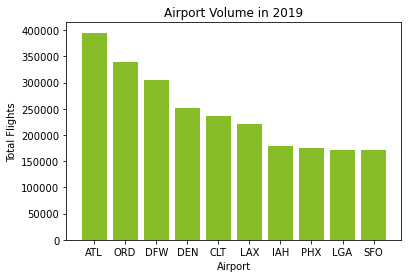

In [4]:
# Setting counts variable to see which airports have the most flight volume and graphing 
counts = df_2019.groupby('ORIGIN')['ORIGIN'].count()
big_airports = counts.sort_values(ascending=False).head(10)

x_values= big_airports.index
y_values= big_airports.values

fig, ax = plt.subplots()

ax.bar(x_values, y_values, color='#86BC25')

ax.set_title('Airport Volume in 2019')
ax.set_xlabel('Airport')
ax.set_ylabel('Total Flights')

plt.show()

In [5]:
# Sorting the top 10 airports by volume and assigning a variable to that list
airport_names = big_airports.index
airports = airport_names.tolist()

# Setting the dataframe to only contain flights by top 10 airport volume
df_2019 = df_2019.loc[df_2019['ORIGIN'].isin(airports) & df_2019['DEST'].isin(airports)]

In [6]:
# Look at the reduction in size!
df_2019.shape

(486282, 21)

Next, I created a "Delay" column that was set to the value of 1 for any flights that had any delay listed in the code, 0 if it was on time. After the "Delay" column was created the other columns were dropped as they were not needed for the rest of the analysis.

In [7]:
# Creating Delay column
df_2019['Delay'] = np.where((df_2019['CARRIER_DELAY'] > 0) | 
                       (df_2019['WEATHER_DELAY'] > 0) | 
                       (df_2019['NAS_DELAY'] > 0) | 
                       (df_2019['SECURITY_DELAY'] > 0) | 
                       (df_2019['ARR_DELAY'] > 0) |
                       (df_2019['DEP_DELAY'] > 0) |
                       (df_2019['LATE_AIRCRAFT_DELAY'] > 0), 1, 0)

# Dropping unnecessary columns 
df_2019.drop(columns=['Unnamed: 20', 
                 'CARRIER_DELAY',
                 'WEATHER_DELAY',
                 'NAS_DELAY',
                 'SECURITY_DELAY',
                 'ARR_DELAY',
                 'DEP_DELAY',
                 'LATE_AIRCRAFT_DELAY'], inplace=True)

# Removing Null values from the following columns
df_2019.dropna(subset=['DEP_TIME', 
                       'TAXI_OUT', 
                       'WHEELS_OFF', 
                       'WHEELS_ON', 
                       'TAXI_IN', 
                       'ARR_TIME', 
                       'AIR_TIME'], inplace=True)

# Renaming columns for easier manipulation later on 
df_2019.rename(columns = {'OP_UNIQUE_CARRIER':'OP_CARRIER'},inplace=True)

The list of carriers is extensive. So, I decided for this proof of concept I wanted to also only focus on only the top national carriers. 

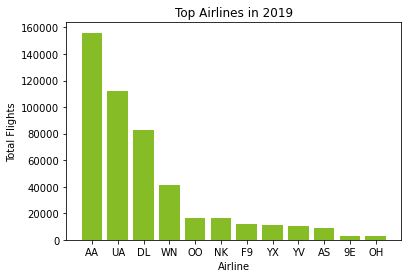

In [8]:
counts_1 = df_2019.groupby('OP_CARRIER')['OP_CARRIER'].count()
biggest_carriers = counts_1.sort_values(ascending=False).head(12)

x_values = biggest_carriers.index
y_values = biggest_carriers.values 

fig, ax = plt.subplots()

ax.bar(x_values, y_values, color='#86BC25')

ax.set_title('Top Airlines in 2019')
ax.set_xlabel('Airline')
ax.set_ylabel('Total Flights')

plt.show()

In [9]:
# Indexing top carriers and adding them to a list called 'airlines'
airline_names = biggest_carriers.index
airlines = airline_names.tolist()

# Flitering data to only include carriers included in airlines 
carrier_list = df_2019['OP_CARRIER'].isin(airlines)
df_model = df_2019[carrier_list]

In [10]:
# Checking data size
df_model.shape

(472097, 14)

In this portion of code, I looked at encoding variables that were non integers and set the "FL_Date" to model freindly values like Day, Month, and Year that can be interpreted by the final models.

In [11]:
# Setting the date column to datetime for extraction
df_model['date'] = pd.to_datetime(df_model['FL_DATE'])

# Extracted the year, month, and day of the week from the new date field
df_model['year'] = df_model['date'].dt.year
df_model['month'] = df_model['date'].dt.month
df_model['day_of_week'] = df_model['date'].dt.dayofweek

# Drop the original date field and FL_DATE
df_model = df_model.drop(columns=['date', 'FL_DATE'])
df_model= df_model[['year', 'month', 'day_of_week', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
                               'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME',
                               'AIR_TIME', 'DISTANCE', 'Delay']]

# Dropped the Null Values from these subsets 
df_model.dropna(subset=['year', 'month', 'day_of_week'], inplace=True)

# Last, I encoded each of the 3 remaining variables 
df_model = pd.get_dummies(df_model, columns=['OP_CARRIER', 'ORIGIN', 'DEST'])

<ipython-input-11-d40d7585f33e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['date'] = pd.to_datetime(df_model['FL_DATE'])
<ipython-input-11-d40d7585f33e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['year'] = df_model['date'].dt.year
<ipython-input-11-d40d7585f33e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

# Modeling

In this section of the analysis notebook I go over the 3 models I used to gather predictions on these 2019 flights.

3 models included in my analysis:
* Logistic Regression
* Random Forest
* XGBoost

Since my analysis will be focusing on binary classification (will or will not) where the pridiction is a 1 or 0 Logistic Regression is a good place to start as it is typically faster, and less computationally expensive when compared to
the other models.

In [12]:
#Verifying all Null values are accounted for
df_model.isnull().sum()

year                 0
month                0
day_of_week          0
OP_CARRIER_FL_NUM    0
DEP_TIME             0
TAXI_OUT             0
WHEELS_OFF           0
WHEELS_ON            0
TAXI_IN              0
ARR_TIME             0
AIR_TIME             0
DISTANCE             0
Delay                0
OP_CARRIER_9E        0
OP_CARRIER_AA        0
OP_CARRIER_AS        0
OP_CARRIER_DL        0
OP_CARRIER_F9        0
OP_CARRIER_NK        0
OP_CARRIER_OH        0
OP_CARRIER_OO        0
OP_CARRIER_UA        0
OP_CARRIER_WN        0
OP_CARRIER_YV        0
OP_CARRIER_YX        0
ORIGIN_ATL           0
ORIGIN_CLT           0
ORIGIN_DEN           0
ORIGIN_DFW           0
ORIGIN_IAH           0
ORIGIN_LAX           0
ORIGIN_LGA           0
ORIGIN_ORD           0
ORIGIN_PHX           0
ORIGIN_SFO           0
DEST_ATL             0
DEST_CLT             0
DEST_DEN             0
DEST_DFW             0
DEST_IAH             0
DEST_LAX             0
DEST_LGA             0
DEST_ORD             0
DEST_PHX   

### Logistic Regression Model

First we are going to start off with setting our X, and y values.

In [13]:
X = df_model.drop('Delay', axis=1)
y = df_model['Delay']

#Setting train test split to automatically split up the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Next, we are going to normalize the values of y, which give us a good insight into the percentage of flights that were delayed(1) vs. not delayed(0). This is particularly helpful in determining if we will need to use class weights or not.

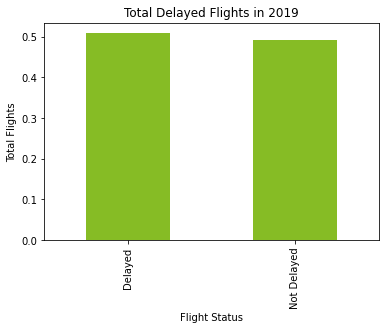

1    0.509078
0    0.490922
Name: Delay, dtype: float64


In [14]:
# Graphing the values 
y.value_counts(normalize=True).plot(kind='bar', color='#86BC25')

# Setting plot features
plt.title('Total Delayed Flights in 2019')
plt.xlabel('Flight Status')
plt.ylabel('Total Flights')
plt.xticks([0, 1], ['Delayed', 'Not Delayed'])
plt.show()
print(y.value_counts(normalize=True))

Since we are dealing with Logistic Regression, data needs to be scaled using a scaler, before fitting the baseline model. 

In [15]:
#Fitting the scalar to non binary train and test data
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

Next, we are going to fit our baseline model and time the performance for comparison.

In [16]:
# Setting up the baseline model
lr_basemodel = LogisticRegression()

# Timing performance for presentation statistics
start_time = time.time()
lr_basemodel.fit(X_train, y_train)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Make predictions with the model
start_time = time.time()
predictions_lr_bm = lr_basemodel.predict(X_test)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

# Printing out times and F1 score for the baseline LR model
print("Training time: {} seconds".format(training_time))
print("Prediction time: {} seconds".format(prediction_time))
print('F1 score for the base model is: ',f1_score(y_test,predictions_lr_bm))

Training time: 1.9225378036499023 seconds
Prediction time: 0.017599105834960938 seconds
F1 score for the base model is:  0.6544705415294155


### Tuning the Logistic Regression Basemodel

Tuning is very important... In this section we will be using SKlearn's tool GridSearchCV to check all parameter combinations to give us the optimal model.

In [17]:
#Initializing the model
lr = LogisticRegression(max_iter = 500)

#Setting up the hyperperameters
weights = np.linspace(0,0.99,100)
param = {'C': [0.001, 0.01, 0.1, 1], 
         'penalty': ['l1','l2'], 
         'solver':['liblinear']}
folds = KFold(n_splits = 5, shuffle=True)

# Fitting the model to find optimal hyperperameters 
model = GridSearchCV(estimator= lr, param_grid=param, scoring="f1", cv=folds, return_train_score=True)
model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             return_train_score=True, scoring='f1')

In [18]:
#Finding the optimal perameters
print(model.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Now that the model has the optimal hyperperameters we will fit the final tuned model and record the confusion matrix, accuracy, precision, recall, and f1 score to compare with RandomForest and XGboost.

In [19]:
# Setting up tuned model with best hyperperameters
lr_tuned=LogisticRegression(max_iter=500, 
                            C=1, 
                            penalty='l2', 
                            solver='liblinear')

# fitting the model
lr.fit(X_train, y_train)

#Making predictions
predictions_lr = lr.predict(X_test)

#Printing results of tuned model
print('F1 score for the LR tuned model is: ',f1_score(y_test,predictions_lr))
print('Precision for the LR tuned model is:',precision_score(y_test, predictions_lr))
print('Recall for the LR tuned model is:',recall_score(y_test, predictions_lr))
print('Accuracy for the LR tuned model is:',accuracy_score(y_test, predictions_lr))

F1 score for the LR tuned model is:  0.6544705415294155
Precision for the LR tuned model is: 0.6723693203112944
Recall for the LR tuned model is: 0.6375
Accuracy for the LR tuned model is: 0.6589387841558991


In [20]:
print(confusion_matrix(y_test, predictions_lr))

[[31719 14861]
 [17342 30498]]


### Random Forest Model

First, we reset the train test split as RandomForest can work with data that is not scaled. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Next we fit our RandomForest basemodel and time the performance for comparison.

In [22]:
# Setting up the baseline model
rf_basemodel = RandomForestClassifier(max_depth=5, random_state=12)

# Timing performance for presentation statistics
start_time = time.time()
rf_basemodel.fit(X_train, y_train)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Make predictions with the model
start_time = time.time()
predictions_rf_bm = rf_basemodel.predict(X_test)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

# Printing out times and F1 score for the baseline RF model
print("Training time: {} seconds".format(training_time))
print("Prediction time: {} seconds".format(prediction_time))
print('F1 score for the RandomForest base model is: ',f1_score(y_test,predictions_rf_bm))

Training time: 41.25457191467285 seconds
Prediction time: 0.7672271728515625 seconds
F1 score for the RandomForest base model is:  0.6535620633745021


### Tuning the RandomForest Basemodel

Once again using GridSearchCV to tune model performance for best overall statistics.

In [23]:
# Initializing the model
rf_basemodel = RandomForestClassifier()

#Setting up the hyperperameters
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# Fitting the model to find optimal hyperperameters 
CV_rfc = GridSearchCV(estimator=rf_basemodel, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [24]:
# Finding the best perameters
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}


Now that the model has the optimal hyperperameters we will fit the final tuned model and record the confusion matrix, accuracy, precision, recall, and f1 score to compare with Logistic Regression and XGboost.

In [25]:
# Setting up tuned model with best hyperperameters
rf_tuned = RandomForestClassifier(criterion='gini', 
                                  max_depth=8, 
                                  max_features='sqrt', 
                                  n_estimators= 200, 
                                  random_state=12)

# Fitting the model
rf_tuned.fit(X_train, y_train)

# Making predictions
predictions_rf = rf_tuned.predict(X_test)

# Printing results of tuned model
print('F1 score for the RandomForest tuned model is: ',f1_score(y_test,predictions_rf))
print('Precision for the RandomForest tuned model is:',precision_score(y_test, predictions_rf))
print('Recall for the RandomForest tuned model is:',recall_score(y_test, predictions_rf))
print('Accuracy for the RandomForest tuned model is:',accuracy_score(y_test, predictions_rf))

F1 score for the RandomForest tuned model is:  0.6633482175536197
Precision for the RandomForest tuned model is: 0.6637160734090861
Recall for the RandomForest tuned model is: 0.6629807692307692
Accuracy for the RandomForest tuned model is: 0.6590446939207795


In [26]:
confusion_matrix(y_test, predictions_rf)

array([[30510, 16070],
       [16123, 31717]], dtype=int64)

### XGBoost Model

First, we reset the train test split as XGBoost can work with data that is not scaled.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Next we fit our XGBoost basemodel and time the performance for comparison.

In [28]:
# Setting up the baseline model
model_xg = xgb.XGBClassifier()

# Timing performance for presentation statistics
start_time = time.time()
model_xg.fit(X_train, y_train)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Make predictions with the model
start_time = time.time()
predictions_XG_bm = model_xg.predict(X_test)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

# Printing out times and F1 score for the baseline RF model
print("Training time: {} seconds".format(training_time))
print("Prediction time: {} seconds".format(prediction_time))
print('F1 score for the XGBoost base model is: ',f1_score(y_test,predictions_XG_bm))

Training time: 17.059042930603027 seconds
Prediction time: 0.3152120113372803 seconds
F1 score for the XGBoost base model is:  0.7226787899982513


### Tuning the XGBoost Basemodel

Once again using GridSearchCV to tune model performance for best overall statistics.

In [30]:
# Initializing the model
XGBoost_tuned = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

#Setting up the hyperperameters
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

# Fitting the model to find optimal hyperperameters 
grid_search = GridSearchCV(
    estimator=XGBoost_tuned,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose=True
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 111.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 224.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 254.6min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=Non

In [31]:
# Finding the best perameters
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}


Now that the model has the optimal hyperperameters we will fit the final tuned model and record the confusion matrix, accuracy, precision, recall, and f1 score to compare with Logistic Regression and RandomForest.

In [32]:
# Setting up tuned model with best hyperperameters
model_xg1 = xgb.XGBClassifier(learning_rate = 0.1, 
                              max_depth = 9, 
                              n_estimators = 180)

# Fitting the model
model_xg1.fit(X_train, y_train)

# Making predictions
predictions_XG = model_xg.predict(X_test)

# Printing results of tuned model
print('F1 score for the XGBoost tuned model is: ',f1_score(y_test,predictions_XG))
print('Precision for the XGBoost tuned model is:',precision_score(y_test, predictions_XG))
print('Recall for the XGBoost tuned model is:',recall_score(y_test, predictions_XG))
print('Accuracy for the XGBoost tuned model is:',accuracy_score(y_test, predictions_XG))

F1 score for the XGBoost tuned model is:  0.7226787899982513
Precision for the XGBoost tuned model is: 0.7572370831806523
Recall for the XGBoost tuned model is: 0.6911371237458194
Accuracy for the XGBoost tuned model is: 0.731243380639695


In [33]:
confusion_matrix(y_test, predictions_XG)

array([[35980, 10600],
       [14776, 33064]], dtype=int64)

# Final Analysis and Recommendations

After looking over some of the best machine learning models offered for binary classification problems such as this one I can safely and confidently offer a few recommendations for airlines to follow.

First, machine learning models can help airlines drive consumer confidence by accurately predicting which flights will be delayed or not allowing more time for preperation and hopefully decreased flight delay times. The best model for predicting flight delay is XGboost as depicted by the f1 scores below:

In [34]:
print('F1 score for the XGBoost tuned model is: ',f1_score(y_test,predictions_XG))
print('F1 score for the RandomForest tuned model is: ',f1_score(y_test,predictions_rf))
print('F1 score for the Logistic Regression tuned model is: ',f1_score(y_test,predictions_lr))

F1 score for the XGBoost tuned model is:  0.7226787899982513
F1 score for the RandomForest tuned model is:  0.6633482175536197
F1 score for the Logistic Regression tuned model is:  0.6544705415294155


Second, I would like to introduce weather data such as temperature, wind, humidity, and precipitation to increase model performance by offering more real time delay inducing factors to the model.

Finally, I would implement a team to run this analyis. Due to my constraints with computing power I was only able to effectively run one year of data through the model but with all ten years of data being run through these models the f1 score would increase and flights could be better predicted.